# Feather in Focus 

Classifying Images of Bird Species using CNN with a pretrained EfficentNet_B0 model. 


Group 27: Alberto Scinetti, Laura Vochiţa, Mickey van Riemsdijk, Melle Koers
Melle Koers

In [16]:

import sys
sys.path.append('src/')
import numpy as np
import pandas as pd
import os
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from PIL import Image
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from sklearn.model_selection import train_test_split
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision.models import (
    resnet18, ResNet18_Weights,
    efficientnet_b0, EfficientNet_B0_Weights,
    mobilenet_v3_large, MobileNet_V3_Large_Weights,
)
from collections import Counter
from data_utils import (get_mean_and_std, BirdDataset)

## Calculate Mean and SD of the images (for later transformation)

In [11]:
# paths 
training_dataset_path = ("data/train_images/train_images")
testing_dataset_path = ("data/test_images/test_image")

training_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor()])

In [12]:
# loader + dataset
train_dataset = torchvision.datasets.ImageFolder(root = training_dataset_path,
                                                 transform = training_transforms)

train_loader = torch.utils.data.DataLoader(dataset = train_dataset, batch_size = 32,
                                           shuffle = False)

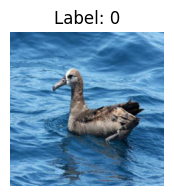

In [13]:
# Helper function to denormalize and display the image
def imshow(image, title=None):
    image = image.numpy().transpose((1, 2, 0))  # Convert tensor to NumPy and transpose dimensions (C, H, W) -> (H, W, C)
    plt.imshow(image)
    if title:
        plt.title(title)
    plt.axis('off')

# Display the first 10 images from the train_loader
for batch_idx, (images, labels) in enumerate(train_loader):
    for i in range(min(10, len(images))):  # Only display up to 10 images
        plt.figure(figsize=(2, 2))
        imshow(images[i])  # Visualize the image
        plt.title(f"Label: {labels[i].item()}")
        plt.show()
    break  # Stop after the first batch

In [5]:
# calculate images mean and std
mean, std = get_mean_and_std(train_loader)

print(mean)
print(std)

tensor([0.3095, 0.5025, 0.6582])
tensor([0.1558, 0.1620, 0.1881])


## Image DataSet Preparation

In [6]:
# transfomr images for best results 
train_transform = transforms.Compose([
    transforms.Resize((224, 224)), # 224 before 
    transforms.RandomApply(torch.nn.ModuleList([transforms.GaussianBlur(kernel_size=3,sigma=(0.2, 5))]),p=0.15),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

## to do later, no flip or rotation just Resize, ToTensor and Normalize !!
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

In [7]:
###### since the data doesnt follow a folder class structure, create a custom pytorch DataSet

annotations = pd.read_csv("data/train_images.csv")
annotations['label'] = annotations['label'] - 1


# Split annotations into training and testing
train_annotations, test_annotations = train_test_split(
    annotations, test_size=0.1, random_state=50, stratify=annotations['label'])

# Class weights (for class imabalnce!!)
# did not really perform better with this
class_counts = train_annotations['label'].value_counts()
total_samples = len(train_annotations)
num_classes = len(class_counts)
class_weights = torch.tensor([
    total_samples / (num_classes * count) for count in class_counts.sort_index()
], dtype=torch.float32)

In [9]:
#### Custom dataset defined in data utilis

# Example of loading the dataset
dataset_train = BirdDataset(csv_file=train_annotations, root_dir="data/train_images/train_images", transform=train_transform)
# we use a mini batch withìch only contins 32 images,
# lets see later how the model foes and we ccan change batch size
trainloader = torch.utils.data.DataLoader(dataset_train, batch_size=32, shuffle = True) 


dataset_test = BirdDataset(csv_file=test_annotations, root_dir="data/train_images/train_images", transform=test_transform)
testloader = torch.utils.data.DataLoader(dataset_test, batch_size=32, shuffle=False)

#get the first image
image, label = dataset_train[2]
len(dataset_train)

3533

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.5000079..4.432141].


labels:  tensor([174, 132, 149, 177, 156,  27,   3,  87,  66,  71, 155,  56,  87,  51,
        132,  20, 196,  44,  76,  49,  62,  33, 179,  48,  12,  40,  61,  49,
         48,  39,  69, 171])


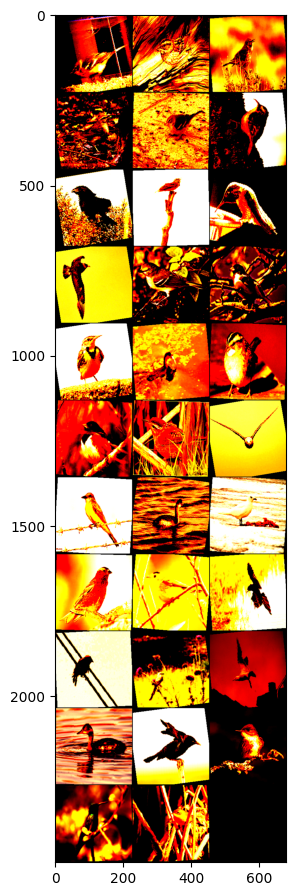

In [14]:
def show_transformed_images(dataset):
    loader = torch.utils.data.DataLoader(dataset, batch_size = 32, shuffle = True)
    batch = next(iter(loader))
    images, labels = batch

    grid = torchvision.utils.make_grid(images, nrow=3)
    plt.figure(figsize = (11,11))
    plt.imshow(np.transpose(grid, (1,2,0)))
    print("labels: ", labels)

# show the images
show_transformed_images(dataset_train)

## Train the NN 

In [15]:
def set_device():
    if torch.cuda.is_available():
        dev = "cuda:0"
    else:
        dev = "cpu"
    return torch.device(dev)

print(set_device())

cpu


In [19]:
# EFFICENT NET MODEL
efficientnet_model = efficientnet_b0(weights=EfficientNet_B0_Weights.IMAGENET1K_V1)

# Number of classes in the dataset
number_of_classes = 200

# Replace the classifier in EfficientNet to match the number of classes
num_ftrs = efficientnet_model.classifier[1].in_features
efficientnet_model.classifier = nn.Linear(num_ftrs, number_of_classes)

# Select the device
device = set_device()  # Assuming set_device() returns either 'cuda' or 'cpu'
efficientnet_model = efficientnet_model.to(device)


# weights
#class_weights = class_weights.to(device)

# Loss function
loss_fn = nn.CrossEntropyLoss()

# Optimizer
optimizer = optim.SGD(efficientnet_model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.003)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)


In [20]:
# compute class weights for class imbalance 
# Class weights (for class imabalnce!!)
#
class_counts = train_annotations['label'].value_counts()


# Convert class counts to class weights
total_samples = len(train_annotations)
num_classes = len(class_counts)

# Compute weights
class_weights = torch.tensor([
    total_samples / (num_classes * count) for count in class_counts.sort_index()
], dtype=torch.float32)

# Print the computed class weights
print("Class Weights:", class_weights)

Class Weights: tensor([0.5698, 0.5698, 0.5888, 0.5698, 1.0391, 1.2618, 0.7066, 0.8412, 0.5698,
        0.5698, 0.5888, 0.6309, 0.5888, 0.5888, 0.5888, 0.5888, 0.6091, 0.9814,
        0.6091, 0.6091, 0.6091, 0.6309, 0.6091, 0.7360, 0.6309, 0.6309, 0.6309,
        0.6309, 0.6309, 0.6309, 0.6543, 0.7066, 0.6543, 0.6543, 0.6543, 0.6543,
        0.6543, 0.6794, 0.6794, 0.6794, 0.6794, 0.6794, 0.6794, 0.6794, 0.7066,
        0.7066, 0.7066, 0.7066, 0.7066, 0.7066, 0.7360, 0.7360, 0.7360, 0.7360,
        0.7360, 0.7360, 0.7360, 0.7680, 0.7680, 0.7680, 0.7680, 0.7680, 0.7680,
        0.7680, 0.8030, 0.8030, 0.7680, 0.8030, 0.7680, 0.8030, 0.8030, 0.8030,
        0.8030, 0.8030, 0.8030, 0.8030, 0.8030, 0.8412, 0.8412, 0.8412, 0.8412,
        0.8412, 0.8412, 0.8832, 0.8832, 0.8832, 0.8832, 0.8832, 0.8832, 0.8832,
        0.9297, 0.9297, 0.9297, 0.9297, 0.9297, 0.9297, 0.9297, 0.9814, 0.9814,
        0.9814, 0.9814, 0.9814, 0.9814, 1.0391, 1.0391, 1.0391, 1.0391, 1.0391,
        1.0391, 1.0391, 1

In [13]:
def save_checkpoint(model, epoch, optimizer, best_acc):
    state = {
        "epoch" : epoch ,
        "model" : model.state_dict(),
        "best accuracy" : best_acc,
        "optimizer" : optimizer.state_dict(),
    }
    torch.save(state, "model_best_checkpoint.pth.tar")

In [14]:
def train_nn(model, train_loader, test_loader, criterion, optimizer, n_epochs, scheduler):
    device = set_device()
    best_acc = 0

    # for loop for each epoch
    for epoch in range(n_epochs):
        print(f"Epoch number is {epoch}")
        model.train()
        running_loss = 0.0
        running_correct = 0.0
        total = 0


        # going thoruh each batch
        for data in train_loader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            total += labels.size(0)

            optimizer.zero_grad()

            outputs = model(images)   # outputs from the bini batch which the model produces

            _, predicted = torch.max(outputs.data, 1)  # the predictions

            loss = criterion(outputs, labels) # loss function

            loss.backward() # backpropagate

            optimizer.step()

            running_loss += loss.item()
            running_correct += (predicted == labels).sum().item()
        
        scheduler.step()
        epoch_loss = running_loss/len(train_loader)
        epoch_acc = 100.00 * running_correct / total

        print(f"Training data set got {running_correct} out of {total} images correctly (accuracy: {epoch_acc}%). Epoch loss = {epoch_loss}")

        test_dataset_acc = evaluate_model_on_test_set(model, test_loader)

        if (test_dataset_acc > best_acc):
            best_acc = test_dataset_acc
            save_checkpoint(model, epoch, optimizer, best_acc)

    print("finished")

    return model

In [15]:
def evaluate_model_on_test_set(model, test_loader):
    model.eval()
    predicted_correctly_on_epoch = 0
    total = 0
    device = set_device()

    # deactivate autogradient engine
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            total += labels.size(0)

            outputs = model(images)   # outputs from the bini batch which the model produces

            _, predicted = torch.max(outputs.data, 1)  # the predictions

            predicted_correctly_on_epoch += (predicted == labels).sum().item()

    epoch_acc = 100.00 * predicted_correctly_on_epoch / total
    print(f"Testing datd, predicted correctly on epoch: {predicted_correctly_on_epoch} out of {total}, acc = {epoch_acc} % ")

    return epoch_acc

In [21]:
train_nn(efficientnet_model, trainloader, testloader, loss_fn, optimizer, 12, exp_lr_scheduler)

Epoch number is 0
Training data set got 374.0 out of 3533 images correctly (accuracy: 10.585904330597225%). Epoch loss = 4.708525449306041
Testing datd, predicted correctly on epoch: 108 out of 393, acc = 27.480916030534353 % 
Epoch number is 1
Training data set got 1431.0 out of 3533 images correctly (accuracy: 40.50382111519955%). Epoch loss = 2.7343327966896265
Testing datd, predicted correctly on epoch: 185 out of 393, acc = 47.07379134860051 % 
Epoch number is 2
Training data set got 2115.0 out of 3533 images correctly (accuracy: 59.86413812623832%). Epoch loss = 1.693033688777202
Testing datd, predicted correctly on epoch: 209 out of 393, acc = 53.18066157760814 % 
Epoch number is 3
Training data set got 2530.0 out of 3533 images correctly (accuracy: 71.61052929521652%). Epoch loss = 1.184358963021287
Testing datd, predicted correctly on epoch: 234 out of 393, acc = 59.541984732824424 % 
Epoch number is 4
Training data set got 2873.0 out of 3533 images correctly (accuracy: 81.318

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [22]:
# best model withing my epochs
checkpoint = torch.load("model_best_checkpoint.pth.tar")
print(checkpoint["epoch"])
print(checkpoint["best accuracy"])

10
69.72010178117048


/tmp/ipykernel_23/2734306603.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("/kaggle/working/model_best_checkpoint.pth.tar")


In [21]:
# find best model and save it 
efficientnet_model = models.efficientnet_b0(pretrained=True) 

number_of_classes = 200
num_ftrs = efficientnet_model.classifier[1].in_features


efficientnet_model.classifier[1] = nn.Linear(num_ftrs, number_of_classes)


state_dict = checkpoint["model"]

'
state_dict["classifier.1.weight"] = state_dict.pop("classifier.weight")
state_dict["classifier.1.bias"] = state_dict.pop("classifier.bias")
efficientnet_model.load_state_dict(state_dict)


torch.save(efficientnet_model, "best_model.pth")

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [22]:
# load the best model from before
model = torch.load("best_model.pth")

final_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

/tmp/ipykernel_23/1302153705.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load("/kaggle/working/best_model.pth")


In [23]:
def classifiy(model, image_transforms, image_path_list):
    model = model.eval()
    predictions = []
    for image_path in image_path_list:
        image = Image.open(image_path)
        image = image.convert('RGB')
        image = image_transforms(image).float()
        image = image.unsqueeze(0)

        output = model(image)
        _, predicted = torch.max(output.data, 1)
        predictions.append(predicted)

    return predictions

In [24]:
# preprocessing for prediction 
test_images = pd.read_csv("data/test_images_path.csv")
list(test_images["image_path"])
test_images["image_path"] = "data/test_images/test_images" + test_images["image_path"]
path_list = list(test_images["image_path"])


In [26]:
# predict 
predictions = classifiy(model, final_test_transform, path_list)

In [27]:
int_predictions = [int(t.item()) for t in predictions]
len(int_predictions)
#int_predictions

4000

In [28]:
# need to adjust label since i globally subtracted 1 before
predictions_adjusted = list(map(lambda x: x + 1, int_predictions))

In [29]:
test_images_sample = pd.read_csv("data/test_images_sample.csv")
test_images_sample["label"] = predictions_adjusted
test_images_sample

,id,label
0,1,67
1,2,39
2,3,74
3,4,12
4,5,74
...,...,...
3995,3996,160
3996,3997,20
3997,3998,135
3998,3999,59


In [30]:
# save prediction file 
test_images_sample.to_csv('predictions.csv', index=False)